In [1]:
%matplotlib inline
from torch import nn
import torch 
from torch.nn import functional as F
from d2l import torch as d2l

num_steps , batch_size = 35 , 32 
train_iter , vocab = d2l.load_data_time_machine( batch_size  , num_steps )

In [2]:
num_hiddens = 256
#词表大小我们可以看作输入的特征------> ( 词表大小 ， 隐藏单元数 )，这与一个普通linear的输入输出类似，linear是单元数->单元数
#rnn也可以看做单元数->单元数，但其实心里要清楚计算方式是不同的，linear只需要一个输入就行， rnn还需要借助一个过往隐藏状态state
rnn_layer =  nn.RNN( len( vocab ) , num_hiddens )

In [5]:
mlp_linear = nn.Linear( 2 ,4 )
#(  批量大小 ， 特征 )
x = torch.ones( 2,2 )
#(  批量大小 ， 特征 ) -> ( 批次大小 ， 隐藏单元 )
mlp_linear( x )

tensor([[ 0.1609, -0.1275, -0.6943, -0.5189],
        [ 0.1609, -0.1275, -0.6943, -0.5189]], grad_fn=<AddmmBackward>)

In [6]:
#隐藏状态张量大小：(  隐藏层数 ， 批次数 ， 隐藏单元数  )
state = torch.randn( 1 , batch_size , num_hiddens )
state.shape

torch.Size([1, 32, 256])

In [5]:
x = torch.rand(  size= ( num_steps , batch_size , len( vocab )  ))
y , new_state  = rnn_layer( x , state )#可以通过零初始隐藏状态进行计算，当然如果不传入也是可以的
y.shape , new_state.shape #注意：这里是没有输出层的张量，也就是说没有输出权值，这里的shape为隐藏状态的输出shape
#( 时间步 ， 批次大小 ， 隐藏单元数 )   ( 隐藏层数 ， 批次大小，  隐藏单元数 )

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [4]:
x = torch.rand(  size= ( num_steps , batch_size , len( vocab )  ))
y , new_state  = rnn_layer( x  )#初始隐藏层状态可以不定义,这里就只涉及到x与初始输入权值的计算，并没有涉及到隐藏状态与隐藏状态权值的计算
y.shape , new_state.shape #注意：这里是没有输出层的张量，也就是说没有输出权值，这里的shape为隐藏状态的输出shape
#( 时间步 ， 批次大小 ， 隐藏单元数 )   ( 隐藏层数 ， 批次大小，  隐藏单元数 )

(<bound method Module.state_dict of RNN(28, 256)>,
 torch.Size([35, 32, 256]),
 torch.Size([1, 32, 256]))

In [7]:
class RNNModel( nn.Module ):
    #这个类对计算方式进行打包，rnn_layer可以是rnn,lstm,gru等等，我们需要词表大小，隐藏单元就不需要了
    #因为在nn.RNN等高级api里有hidden_size的属性,之后我们通过net( X , state )的形式得到 ( y , new_state)
    #这与train_epoch_ch8中的y_hat , state是完全契合的。
    #总之 ，如果我们采用高级api的方式，我们省略了自己写权值，直接传入rnn变体算子和词表大小就可以得到输出和新的隐藏状态。
    def __init__( self   , rnn_layer , vocab_size ):
        super().__init__()
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        #从网络属性中提取出隐藏单元数
        self.num_hiddens = self.rnn.hidden_size
        if not  self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear( self.num_hiddens , self.vocab_size )
        else:
            self.num_directions = 2 
            self.linear = nn.Linear( self.num_hiddens ,  self.vocab_size )
        
    def forward( self , inputs , state ):
        #( 批次大小 ， 时间步 )-----> ( 时间步 ， 批次大小 ， 词表大小)
        X = F.one_hot( inputs.T.long() , self.vocab_size  ).type( torch.float32 )
        #( 时间步 ， 批次大小 ， 词表大小) --->  Y( 时间步 ， 批次大小 ， 隐藏单元数 ),state( 隐藏层数 ， 批次大小，  隐藏单元数 )
        Y , state = self.rnn( X , state )
        #使用reshape将( 时间步 , 批次大小 ，隐藏单元数 )----->outputs( 时间步*批次大小 ， 隐藏单元数 )
        #目的是得到( 时间步*批次大小 ， 词表大小 )，这样可以直接与y(一维张量标签)进行loss
        outputs = self.linear( Y.reshape( -1 , Y.shape[-1]) )
        return outputs , state
    
    def begin_state( self , device , batch_size  =  1 ):
        #这里batch_size给了1，实际上上我们在train_epoch_ch8中已经对batch_size赋值为X.shape[0],也就是批次大小(此时的X为刚从train_iter拿出的词元)
        if not isinstance( self.rnn , nn.LSTM ):
            # `nn.GRU` 以张量作为隐藏状态
            return torch.zeros( size= (self.num_directions*self.rnn.num_layers , 
                                batch_size , self.num_hiddens)  ,  device= device )
        else:
            # `nn.LSTM` 以张量作为隐藏状态，这里不知道什么意思，暂且复制
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

perplexity 1.1, 168606.9 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


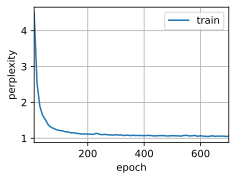

In [10]:
now_device = d2l.try_gpu()
num_epochs , lr = 700 , 0.1
net = RNNModel( rnn_layer ,  len( vocab ) )
net = net.to( now_device )
d2l.train_ch8( net , train_iter , vocab , lr , num_epochs , now_device   )